# Taller: Análisis de Tendencias para Google y Microsoft

En este taller analizaremos los datos de precios para Google y Microsoft (símbolos `GOOGL` y `MSFT`) utilizando la base `prices.csv`.

El objetivo es:

- Filtrar los datos para estas dos empresas.
- Convertir la columna de fecha de forma robusta, ya que diferentes empresas pueden tener distintos formatos de fecha.
- Ordenar los datos por fecha.
- Aplicar un suavizado (media móvil) para ver la tendencia general durante el periodo (máximo 2016).
- Generar una gráfica final que integre un storytelling (Setup, Conflict y Resolution) en el análisis de la tendencia.

Responde las siguientes preguntas en el proceso:

1. ¿Cuáles son el primer y último año del dataset para las empresas seleccionadas?
2. ¿Cuántas observaciones tienes para cada empresa?
3. ¿Qué tendencia se observa tras aplicar el suavizado?


In [1]:
!wget https://github.com/javierherrera1996/lecture_analytics/raw/refs/heads/main/time_series.zip
!unzip time_series.zip
!cp -r time_series/* ./

--2025-04-09 22:31:27--  https://github.com/javierherrera1996/lecture_analytics/raw/refs/heads/main/time_series.zip
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/javierherrera1996/lecture_analytics/refs/heads/main/time_series.zip [following]
--2025-04-09 22:31:27--  https://raw.githubusercontent.com/javierherrera1996/lecture_analytics/refs/heads/main/time_series.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15602616 (15M) [application/zip]
Saving to: ‘time_series.zip’

time_series.zip     100%[===================>]  14.88M  88.3MB/s    in 0.2s    

2025-04-09 22:31:27 (88.3 MB/s) - ‘time

## Paso 1: Carga del Dataset y Filtrado de Empresas

Carga el archivo `prices.csv` y filtra únicamente los datos correspondientes a Google y Microsoft.

Pregunta: ¿Qué cantidad de observaciones tienes para cada empresa después del filtrado?

_**Respuesta:**_ Despues de realizar el filtrado cada empresa tiene 1762 observaciones.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import pandas as pd

%matplotlib inline

prices_df = pd.read_csv('prices.csv')

df_filtrado = prices_df[prices_df['symbol'].isin(['GOOGL', 'MSFT'])]

In [3]:
df_filtrado

,date,symbol,open,close,low,high,volume
440,2010-01-04,GOOGL,626.950006,626.750011,624.240011,629.510005,3908400.0
544,2010-01-04,MSFT,30.620001,30.950001,30.590000,31.100000,38409100.0
908,2010-01-05,GOOGL,627.180001,623.990017,621.540016,627.839984,6003300.0
1012,2010-01-05,MSFT,30.850000,30.959999,30.639999,31.100000,49749600.0
1376,2010-01-06,GOOGL,625.860033,608.260035,606.360021,625.860033,7949400.0
...,...,...,...,...,...,...,...
850076,2016-12-28,MSFT,63.400002,62.990002,62.830002,63.400002,14653300.0
850464,2016-12-29,GOOGL,802.330017,802.880005,798.140015,805.750000,1056500.0
850576,2016-12-29,MSFT,62.860001,62.900002,62.730000,63.200001,10250600.0
850964,2016-12-30,GOOGL,803.210022,792.450012,789.619995,803.289978,1728300.0


In [4]:
n = len(df_filtrado)
print(f"Número de observaciones: {n}")

Número de observaciones: 3524


## Paso 2: Conversión Robust a Formato Datetime

Dado que diferentes empresas podrían tener formatos de fecha distintos, convertiremos la columna `date` usando `pd.to_datetime` sin forzar un formato fijo.

Elimina las filas que no se puedan convertir (donde la fecha es `NaT`).

Pregunta: ¿Cuántas filas se descartan por tener fechas inválidas?

_**Respuesta:**_ Se descartan 0 filas por fechas invalidas.

In [5]:
df_filtrado['date'] = pd.to_datetime(df_filtrado['date'])

<ipython-input-5-be094249e2ee>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['date'] = pd.to_datetime(df_filtrado['date'])


In [6]:
df_filtrado = df_filtrado.dropna(subset=['date'])

In [7]:
df_filtrado

,date,symbol,open,close,low,high,volume
440,2010-01-04,GOOGL,626.950006,626.750011,624.240011,629.510005,3908400.0
544,2010-01-04,MSFT,30.620001,30.950001,30.590000,31.100000,38409100.0
908,2010-01-05,GOOGL,627.180001,623.990017,621.540016,627.839984,6003300.0
1012,2010-01-05,MSFT,30.850000,30.959999,30.639999,31.100000,49749600.0
1376,2010-01-06,GOOGL,625.860033,608.260035,606.360021,625.860033,7949400.0
...,...,...,...,...,...,...,...
850076,2016-12-28,MSFT,63.400002,62.990002,62.830002,63.400002,14653300.0
850464,2016-12-29,GOOGL,802.330017,802.880005,798.140015,805.750000,1056500.0
850576,2016-12-29,MSFT,62.860001,62.900002,62.730000,63.200001,10250600.0
850964,2016-12-30,GOOGL,803.210022,792.450012,789.619995,803.289978,1728300.0


In [8]:
df_filtrado.isnull().sum()

,0
date,0
symbol,0
open,0
close,0
low,0
high,0
volume,0


## Paso 3: Ordenar Datos y Análisis Inicial

Ordena los datos por la columna `date` para cada empresa y determina:

- ¿Cuál es el primer año y el último año para cada empresa?
- ¿Cuántas observaciones hay en total para el periodo (recordando que la fecha máxima es 2016)?

_**Repsuestas:**_
- Para cada empresa, el primer año es el 2010 y el último año es el 2016.
- El total de observaciones hasta el 2016 son 3524.

In [9]:
df_filtrado = df_filtrado.sort_values(by='date')
df_filtrado

,date,symbol,open,close,low,high,volume
440,2010-01-04,GOOGL,626.950006,626.750011,624.240011,629.510005,3908400.0
544,2010-01-04,MSFT,30.620001,30.950001,30.590000,31.100000,38409100.0
908,2010-01-05,GOOGL,627.180001,623.990017,621.540016,627.839984,6003300.0
1012,2010-01-05,MSFT,30.850000,30.959999,30.639999,31.100000,49749600.0
1376,2010-01-06,GOOGL,625.860033,608.260035,606.360021,625.860033,7949400.0
...,...,...,...,...,...,...,...
850076,2016-12-28,MSFT,63.400002,62.990002,62.830002,63.400002,14653300.0
850464,2016-12-29,GOOGL,802.330017,802.880005,798.140015,805.750000,1056500.0
850576,2016-12-29,MSFT,62.860001,62.900002,62.730000,63.200001,10250600.0
850964,2016-12-30,GOOGL,803.210022,792.450012,789.619995,803.289978,1728300.0


In [10]:
primer_año = df_filtrado.groupby('symbol')['date'].min().dt.year
último_año = df_filtrado.groupby('symbol')['date'].max().dt.year
print(f"Primer año: {primer_año}")
print(f"Último año: {último_año}")

Primer año: symbol
GOOGL    2010
MSFT     2010
Name: date, dtype: int32
Último año: symbol
GOOGL    2016
MSFT     2016
Name: date, dtype: int32


In [11]:
df_filtrado_2016 = df_filtrado[df_filtrado['date'].dt.year <= 2016]
total_observaciones = len(df_filtrado_2016)
print(f"Total de observaciones hasta 2016: {total_observaciones}")
df_filtrado_2016

Total de observaciones hasta 2016: 3524


,date,symbol,open,close,low,high,volume
440,2010-01-04,GOOGL,626.950006,626.750011,624.240011,629.510005,3908400.0
544,2010-01-04,MSFT,30.620001,30.950001,30.590000,31.100000,38409100.0
908,2010-01-05,GOOGL,627.180001,623.990017,621.540016,627.839984,6003300.0
1012,2010-01-05,MSFT,30.850000,30.959999,30.639999,31.100000,49749600.0
1376,2010-01-06,GOOGL,625.860033,608.260035,606.360021,625.860033,7949400.0
...,...,...,...,...,...,...,...
850076,2016-12-28,MSFT,63.400002,62.990002,62.830002,63.400002,14653300.0
850464,2016-12-29,GOOGL,802.330017,802.880005,798.140015,805.750000,1056500.0
850576,2016-12-29,MSFT,62.860001,62.900002,62.730000,63.200001,10250600.0
850964,2016-12-30,GOOGL,803.210022,792.450012,789.619995,803.289978,1728300.0


## Paso 4: Visualización Inicial (Setup) – Gráfica de Precios de Cierre

Construye una gráfica inicial que muestre el precio de cierre a lo largo del tiempo para Google y Microsoft.

Utiliza un título multi-línea que comunique la etapa Setup. Por ejemplo:

```
Setup: Serie de Precios sin Suavizado
Datos originales para Google y Microsoft
CONFLICT: IDENTIFICAR MOVIMIENTOS ATÍPICOS
```

Pregunta: ¿Qué diferencias notas entre las series de ambas empresas?

_**Respuesta:**_ Ambas acciones mostraron un crecimiento en sus precios, pero Google tuvo un crecimiento más rápido y con mayores fluctuaciones, mientras que Microsoft tuvo un crecimiento más moderado y estable. Las diferencias en los niveles de precio también fueron notables, con Google negociándose a precios considerablemente más altos que Microsoft.



In [12]:
pivot= pd.pivot_table(df_filtrado, index="date",columns="symbol",values="close")
pivot

symbol,GOOGL,MSFT
date,,
2010-01-04,626.750011,30.950001
2010-01-05,623.990017,30.959999
2010-01-06,608.260035,30.770000
2010-01-07,594.100015,30.450001
2010-01-08,602.020005,30.660000
...,...,...
2016-12-23,807.799988,63.240002
2016-12-27,809.929993,63.279999
2016-12-28,804.570007,62.990002


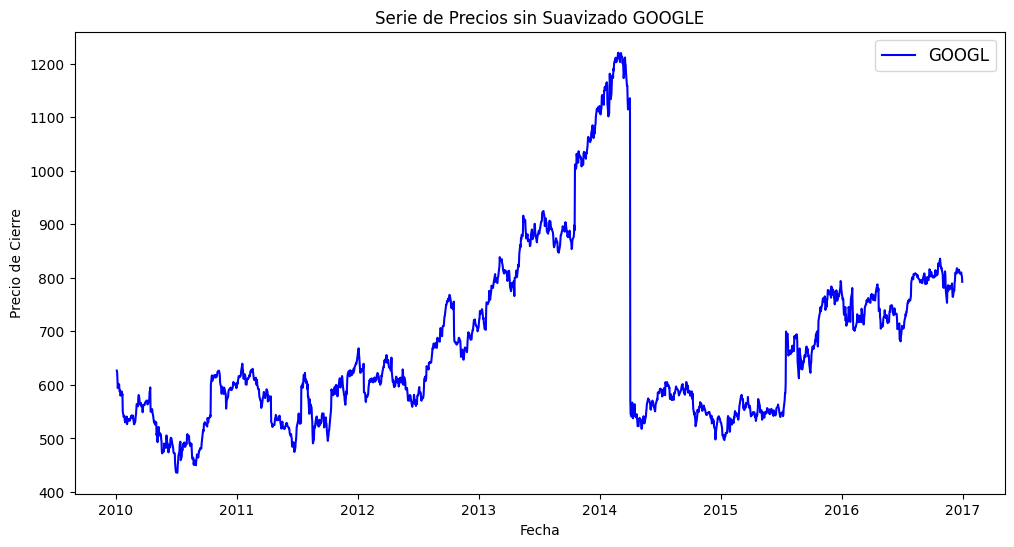

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(pivot['GOOGL'], label='GOOGL',color="Blue")
plt.title('Serie de Precios sin Suavizado GOOGLE')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.legend(fontsize=12)
plt.show()

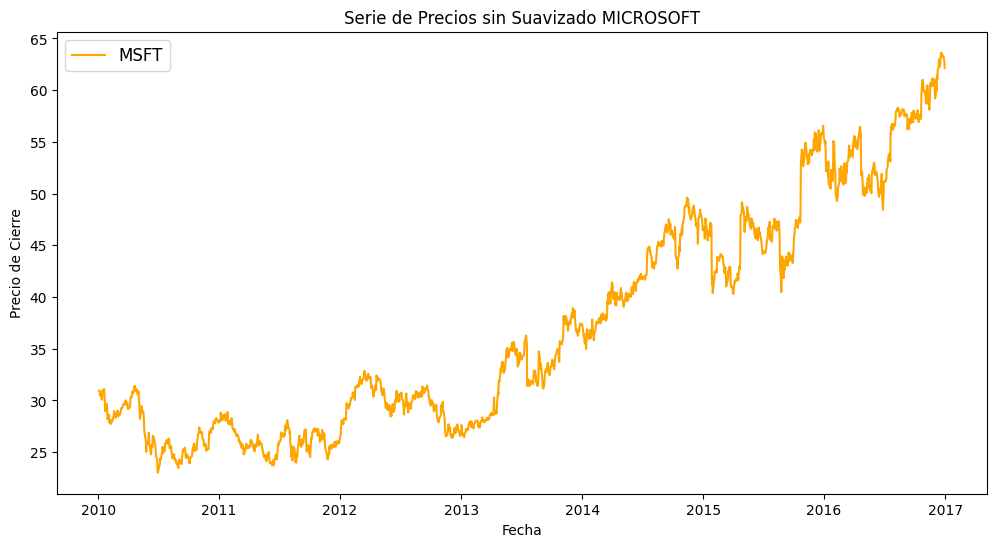

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(pivot['MSFT'], label='MSFT',color="Orange")
plt.title('Serie de Precios sin Suavizado MICROSOFT')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.legend(fontsize=12)
plt.show()

## Paso 5: Aplicar Suavizado (Resolution) – Media Móvil y Análisis de Tendencia

Aplica un suavizado a las series (por ejemplo, una media móvil) para resaltar la tendencia general en los datos.

Pregunta: ¿Qué ventana de suavizado (en días) consideras adecuada para observar la tendencia en el año 2016? ¿Cómo se comporta la tendencia para Google y Microsoft después de suavizar los datos?

In [16]:
pivot['GOOGL_MA'] = pivot['GOOGL'].rolling(window=90).mean()
pivot['MSFT_MA'] = pivot['MSFT'].rolling(window=90).mean()

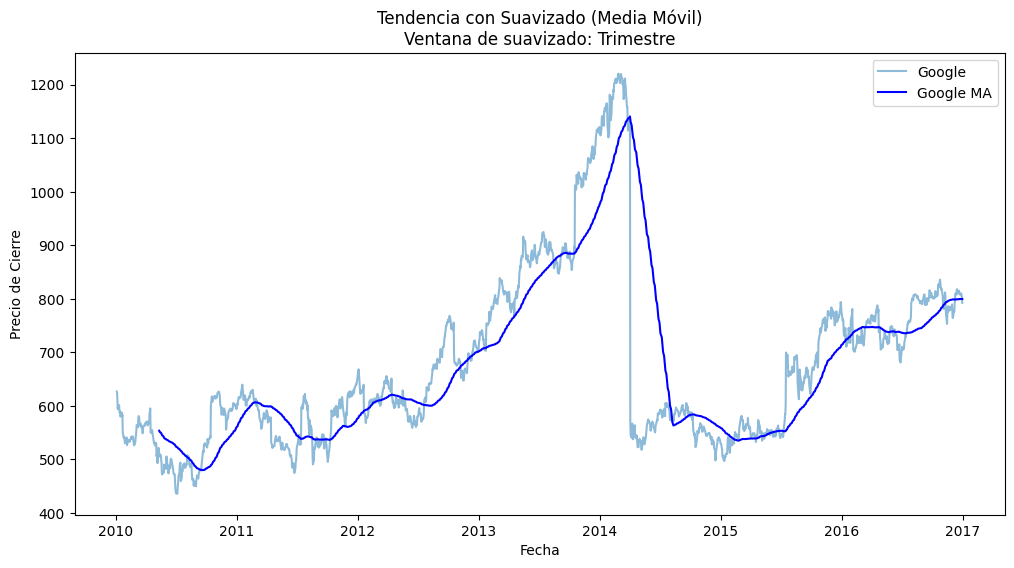

In [18]:
plt.figure(figsize=(12, 6))
window_size = 90
plt.plot(pivot.index, pivot['GOOGL'], label='Google', alpha=0.5)
plt.plot(pivot.index, pivot['GOOGL_MA'], label='Google MA', color='blue')
plt.title('Tendencia con Suavizado (Media Móvil)\nVentana de suavizado: Trimestre')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()

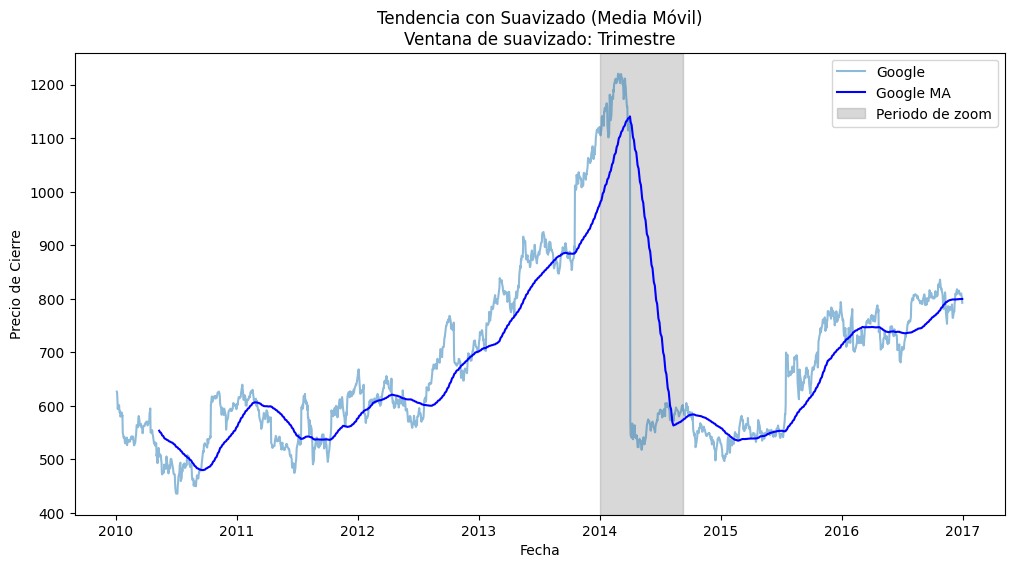

In [20]:
inicio_zoom = '2014-01-01'
fin_zoom = '2014-09-09'

# Convert inicio_zoom and fin_zoom to datetime objects
inicio_zoom = pd.to_datetime(inicio_zoom)
fin_zoom = pd.to_datetime(fin_zoom)

plt.figure(figsize=(12, 6))
# Plot the data first
plt.plot(pivot.index, pivot['GOOGL'], label='Google', alpha=0.5)
plt.plot(pivot.index, pivot['GOOGL_MA'], label='Google MA', color='blue')

# Then highlight the zoom period
plt.axvspan(inicio_zoom, fin_zoom, color='grey', alpha=0.3, label='Periodo de zoom')

plt.title('Tendencia con Suavizado (Media Móvil)\nVentana de suavizado: Trimestre')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.legend()

plt.show()

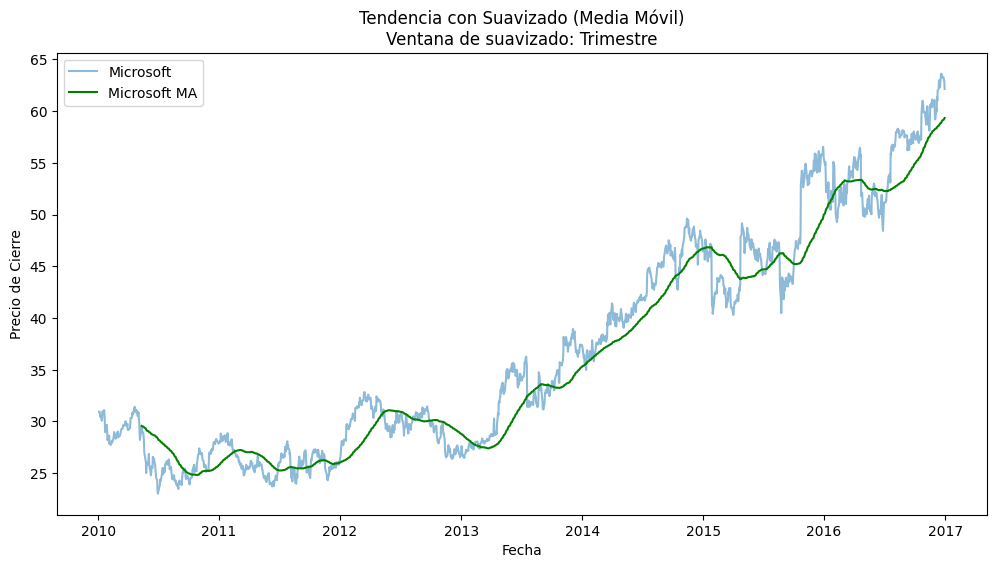

In [27]:
plt.figure(figsize=(12, 6))
window_size = 90
plt.plot(pivot.index, pivot['MSFT'], label='Microsoft', alpha=0.5)
plt.plot(pivot.index, pivot['MSFT_MA'], label='Microsoft MA', color='green')
plt.title('Tendencia con Suavizado (Media Móvil)\nVentana de suavizado: Trimestre')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()

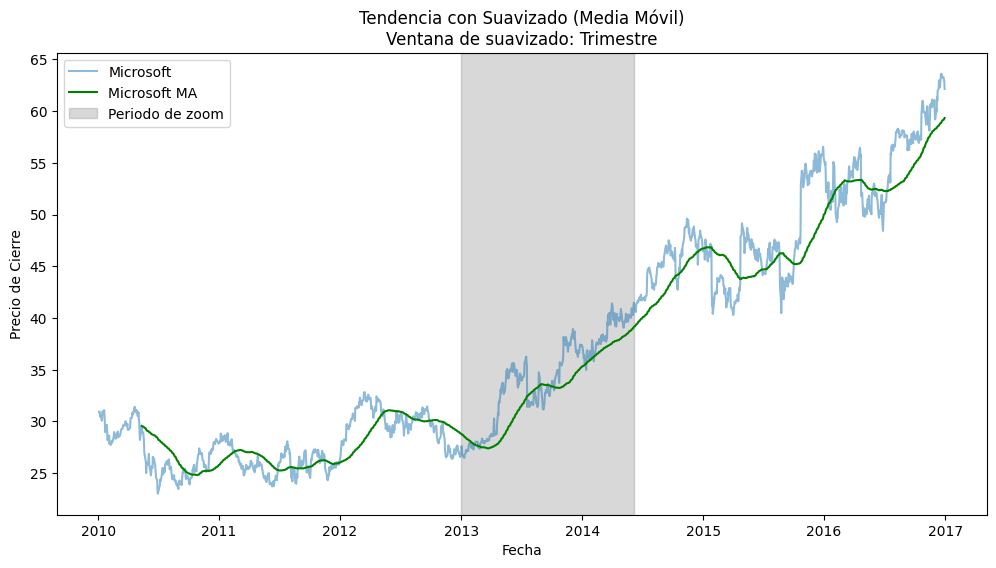

In [31]:
inicio_zoom = '2013-01-01'
fin_zoom = '2014-06-06'

# Convert inicio_zoom and fin_zoom to datetime objects
inicio_zoom = pd.to_datetime(inicio_zoom)
fin_zoom = pd.to_datetime(fin_zoom)

plt.figure(figsize=(12, 6))
# Plot the data first
plt.plot(pivot.index, pivot['MSFT'], label='Microsoft', alpha=0.5)
plt.plot(pivot.index, pivot['MSFT_MA'], label='Microsoft MA', color='green')

# Then highlight the zoom period
plt.axvspan(inicio_zoom, fin_zoom, color='grey', alpha=0.3, label='Periodo de zoom')

plt.title('Tendencia con Suavizado (Media Móvil)\nVentana de suavizado: Trimestre')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()

## Conclusiones y Entrega

En este taller se ha realizado lo siguiente:

- Se cargaron los datos y se filtraron únicamente para las empresas Google y Microsoft.
- Se convirtió la columna `date` de forma robusta, eliminando filas con fechas inválidas.
- Se ordenaron los datos cronológicamente y se obtuvieron información general (primer y último año, número de observaciones por empresa).
- Se construyó una gráfica de storytelling con dos etapas:
  - **Setup:** Visualización inicial de los precios de cierre originales para Google y Microsoft.
  - **Resolution:** Aplicación de un suavizado (media móvil) para resaltar la tendencia general.

Tu entrega final debe incluir las gráficas generadas y una breve explicación de cada paso, respondiendo las preguntas planteadas en el taller.